<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es entrenar un modelo de lenguaje basado en arquitectura de redes recurrentes a partir de un corpus de texto. En el transcurso del ejercicio se explorarán técnicas de generación de secuencias y se medirá la calidad de las mismas calculando la perplejidad. Parte del ejercicio consiste en estructurar adecuadamente el dataset para este problema.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilice el dataset del desafío pasado: Transcripción del debate presidencial.

In [2]:
df = pd.read_csv('debate_presidencial.txt', sep='/n', header=None)
df.head()

C:\Users\CBureu\AppData\Local\Temp\ipykernel_14080\3786229320.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('debate_presidencial.txt', sep='/n', header=None)


,0
0,"TEXTO DEL PRIMER DEBATE PRESIDENCIAL 2023, REA..."
1,"CONVENCIONES PROVINCIAL DE FORUM, CON SEDE EN ..."
2,"ESTERO, A CARGO DE LA UNIVERSIDAD NACIONAL DE ..."
3,DE 2023.
4,MODERADOR RODOLFO BARILI - Hola. Buenas noches...


Consideraremos que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [3]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1145


### Elegir el tamaño del contexto

In [4]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [5]:
text = list(df.loc[:,0])
text

['TEXTO DEL PRIMER DEBATE PRESIDENCIAL 2023, REALIZADO EN EL CENTRO DE',
 'CONVENCIONES PROVINCIAL DE FORUM, CON SEDE EN LA CIUDAD DE SANTIAGO DEL',
 'ESTERO, A CARGO DE LA UNIVERSIDAD NACIONAL DE SANTIAGO DEL ESTERO. 1 DE OCTUBRE',
 'DE 2023.',
 'MODERADOR RODOLFO BARILI - Hola. Buenas noches país. Bienvenidos al debate',
 'presidencial 2023 desde el Forum de Santiago del Estero.',
 'MODERADORA EVANGELINA RAMALLO - Buenas noches. Es un privilegio para nosotros',
 'acompañarlos en este primer debate entre quienes se postulan a Presidente de la Nación',
 'para la elección del próximo 22 de octubre.',
 'RODOLFO BARILI - Y el segundo debate será el próximo domingo en la Facultad de Buenos',
 'Aires en Derecho, el segundo debate, a esta hora, el próximo domingo.',
 'EVANGELINA RAMALLO - En caso de haber ballotage, habrá otro más. El domingo 12 de',
 'noviembre también, en la Facultad de Derecho de la UBA.',
 'RODOLFO BARILI - A ver, los debates electorales constituyen un elemento, un bien 

In [6]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [7]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([ 32.,  13.,  16.,  11.,  17.,  16.,  17.,  12.,  29.,  23., 164.,
        167., 185., 171., 114.,  82.,  49.,  22.,   2.,   3.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ,
        13.1, 14.2, 15.3, 16.4, 17.5, 18.6, 19.7, 20.8, 21.9, 23. ]),
 <BarContainer object of 20 artists>)

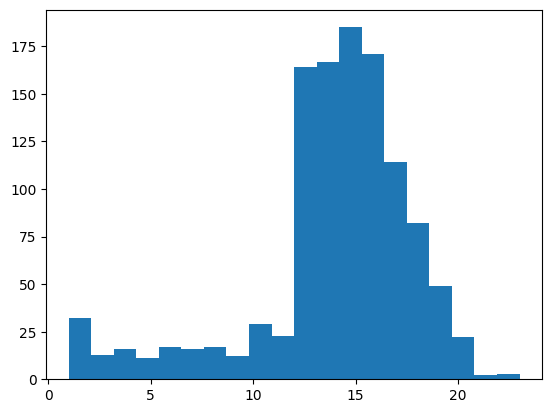

In [8]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [9]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 17


###  Tokenizar

In [10]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [11]:
tokenized_sentences

[[800, 17, 91, 58, 211, 233, 801, 7, 6, 1261, 1],
 [1262, 1263, 1, 573, 13, 1264, 7, 3, 452, 1, 234, 17],
 [285, 4, 261, 1, 3, 374, 167, 1, 234, 17, 285, 802, 1, 325],
 [1, 233],
 [803, 61, 92, 1265, 178, 212, 45, 453, 25, 58],
 [211, 233, 195, 6, 573, 1, 234, 17, 285],
 [804, 72, 73, 178, 212, 9, 12, 574, 15, 54],
 [1266, 7, 28, 91, 58, 148, 805, 19, 806, 4, 179, 1, 3, 213],
 [15, 3, 575, 17, 454, 455, 1, 325],
 [61, 92, 5, 6, 159, 58, 375, 6, 454, 326, 7, 3, 456, 1, 286],
 [287, 7, 37, 6, 159, 58, 4, 81, 457, 6, 454, 326],
 [72, 73, 7, 288, 1, 576, 1267, 1268, 139, 26, 6, 326, 577, 1],
 [1269, 93, 7, 3, 456, 1, 37, 1, 3, 1270],
 [61, 92, 4, 149, 8, 289, 1271, 807, 12, 808, 12, 108, 458],
 [459, 49, 140, 37, 376, 37, 6, 37, 1, 8, 809, 5, 49],
 [807, 12, 808, 1272, 15, 3, 327, 180, 3, 327, 1, 120],
 [290, 7, 28, 168, 1273, 169, 94, 1, 290],
 [72, 73, 5, 9, 14, 32, 2, 3, 196, 810, 1274, 17, 168, 1275, 811, 3],
 [1276, 1, 8, 289, 578],
 [61, 92, 123, 196, 148, 109, 579, 124, 811, 16, 127

In [12]:
max_context_size+1

18

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [13]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

In [14]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [15]:
len(tok_sent)

1004

In [16]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [17]:
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [18]:
print(train_seqs.shape)

(13308, 18)


In [19]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [20]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'que',
 3: 'la',
 4: 'a',
 5: 'y',
 6: 'el',
 7: 'en',
 8: 'los',
 9: 'es',
 10: 'no',
 11: 'lo',
 12: 'un',
 13: 'con',
 14: 'por',
 15: 'para',
 16: 'las',
 17: 'del',
 18: 'una',
 19: 'se',
 20: 'massa',
 21: 'porque',
 22: 'milei',
 23: 'argentina',
 24: '–',
 25: 'al',
 26: 'más',
 27: 'bullrich',
 28: 'este',
 29: 'como',
 30: 'sergio',
 31: 'patricia',
 32: 'eso',
 33: 'si',
 34: 'todos',
 35: 'javier',
 36: 'gracias',
 37: 'derecho',
 38: 'hacer',
 39: 'tiene',
 40: 'schiaretti',
 41: 'vamos',
 42: 'gobierno',
 43: 'réplica',
 44: 'juan',
 45: 'país',
 46: 'le',
 47: 'va',
 48: 'quiero',
 49: 'son',
 50: 'bregman',
 51: 'hay',
 52: 'su',
 53: 'pero',
 54: 'nosotros',
 55: 'nos',
 56: 'ahora',
 57: 'myriam',
 58: 'debate',
 59: 'yo',
 60: 'tenemos',
 61: 'rodolfo',
 62: 'inflación',
 63: 'qué',
 64: 'lucila',
 65: 'trujillo',
 66: 'tener',
 67: 'cuando',
 68: 'está',
 69: 'ser',
 70: 'te',
 71: 'esteban',
 72: 'evangelina',
 73: 'ramallo',
 74: 'les',
 75: 'educaci

In [21]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2828

In [22]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'de': 1, 'que': 2, 'la': 3, 'a': 4, 'y': 5, 'el': 6, 'en': 7, 'los': 8, 'es': 9, 'no': 10, 'lo': 11, 'un': 12, 'con': 13, 'por': 14, 'para': 15, 'las': 16, 'del': 17, 'una': 18, 'se': 19, 'massa': 20, 'porque': 21, 'milei': 22, 'argentina': 23, '–': 24, 'al': 25, 'más': 26, 'bullrich': 27, 'este': 28, 'como': 29, 'sergio': 30, 'patricia': 31, 'eso': 32, 'si': 33, 'todos': 34, 'javier': 35, 'gracias': 36, 'derecho': 37, 'hacer': 38, 'tiene': 39, 'schiaretti': 40, 'vamos': 41, 'gobierno': 42, 'réplica': 43, 'juan': 44, 'país': 45, 'le': 46, 'va': 47, 'quiero': 48, 'son': 49, 'bregman': 50, 'hay': 51, 'su': 52, 'pero': 53, 'nosotros': 54, 'nos': 55, 'ahora': 56, 'myriam': 57, 'debate': 58, 'yo': 59, 'tenemos': 60, 'rodolfo': 61, 'inflación': 62, 'qué': 63, 'lucila': 64, 'trujillo': 65, 'tener': 66, 'cuando': 67, 'está': 68, 'ser': 69, 'te': 70, 'esteban': 71, 'evangelina': 72, 'ramallo': 73, 'les': 74, 'educación': 75, 'o': 76, 'pregunta': 77, 'me': 78, 'mirol': 79, 'usted': 80, 'esta': 

In [23]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'realizado': 2, '2023': 9, 'centro': 1, 'de': 536, 'el': 321, 'debate': 38, 'presidencial': 10, 'primer': 25, 'en': 255, 'del': 118, 'texto': 2, 'con': 141, 'sede': 1, 'convenciones': 1, 'provincial': 1, 'ciudad': 3, 'forum': 3, 'la': 444, 'santiago': 9, 'a': 396, 'universidad': 5, 'octubre': 6, '1': 2, 'nacional': 13, 'estero': 6, 'cargo': 7, 'barili': 25, 'país': 47, 'rodolfo': 35, 'hola': 1, 'al': 68, 'buenas': 12, 'moderador': 2, 'bienvenidos': 4, 'noches': 10, 'desde': 11, 'es': 203, 'para': 136, 'moderadora': 2, 'nosotros': 42, 'ramallo': 31, 'un': 163, 'privilegio': 3, 'evangelina': 31, 'postulan': 2, 'quienes': 2, 'entre': 12, 'presidente': 11, 'nación': 10, 'acompañarlos': 1, 'este': 60, 'se': 95, 'elección': 3, 'próximo': 4, '22': 4, 'será': 5, 'facultad': 4, 'domingo': 6, 'segundo': 14, 'buenos': 6, 'y': 405, 'esta': 28, 'aires': 6, 'derecho': 49, 'hora': 4, '12': 3, 'habrá': 1, 'caso': 7, 'ballotage': 1, 'más': 63, 'haber': 3, 'otro': 16, 'uba': 


### Definir el modelo

In [24]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model.summary()

c:\Users\CBureu\.virtualenvs\NPL-X_gAyYWz\Lib\site-packages\keras\src\layers\core\embedding.py:89: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 17, 5)          │        14,145 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 17, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2829)           │        93,357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,526 (627.05 KB)

 Trainable params: 160,526 (627.05 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from keras.layers import GRU, Bidirectional
from keras.optimizers import Adam

# Definición del modelo
model2 = Sequential()

# Capa de Embedding
model2.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

# Capas GRU bidireccionales
model2.add(Bidirectional(GRU(64, return_sequences=True)))
model2.add(Dropout(0.2))
model2.add(Bidirectional(GRU(64))) 

# Capa Dense con activación ReLU
model2.add(Dense(32, activation='relu'))

# Capa de salida con activación softmax
model2.add(Dense(vocab_size+1, activation='softmax'))

# Compilación del modelo con el optimizador Adam y la pérdida SparseCategoricalCrossentropy
model2.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 17, 5)          │        14,145 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 17, 128)        │        27,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2829)           │        93,357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,390 (833.55 KB)

 Trainable params: 213,390 (833.55 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Definición del modelo
model3 = Sequential()

# Capa de Embedding
model3.add(Embedding(input_dim=vocab_size+1, output_dim=128))

# Capas Bidireccionales LSTM
model3.add(Bidirectional(LSTM(128, return_sequences=True)))
model3.add(Dropout(0.2))
model3.add(Bidirectional(LSTM(128))) 

# Capa Dense con activación ReLU
model3.add(Dense(64, activation='relu'))

# Capa de salida con activación softmax
model3.add(Dense(vocab_size+1, activation='softmax'))

# Compilación del modelo con el optimizador Adam y la pérdida SparseCategoricalCrossentropy
model3.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

model3.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [27]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        # nos movemos en todas las secuencias de los datos de validación
        for seq in self.val_data:

          # armamos todas las subsecuencias
          subseq = [seq[:i] for i in range(len(seq))]
          target = [seq[i] for i in range(len(seq))]
          bb = pad_sequences(subseq, maxlen=max_context_size, padding='pre')

          # utilizamos el modelo para que haga su predicción en cada subsecuencia
          # (son las probabilidades condicionadas)
          predictions = self.model.predict(bb,verbose=0)

          # en `probs`iremos guardando las probabilidades de los términos target
          probs = []

          for idx_seq, idx_vocab in enumerate(target):
              probs.append(predictions[idx_seq,idx_vocab])

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/len(target)))

        # promediamos todos los scores e imprimimos el valor promedio
        print(f'\n mean perplexity: {np.mean(scores)} \n')

### Entrenamiento

In [28]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, mientras más grande mejor.
hist = model.fit(X, y, epochs=100, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/100


414/416 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0413 - loss: 6.7842
 mean perplexity: 803.7033164863511 

416/416 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.0413 - loss: 6.7819
Epoch 2/100
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0483 - loss: 6.0541
 mean perplexity: 916.0059758433096 

416/416 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.0483 - loss: 6.0541
Epoch 3/100
412/416 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0460 - loss: 5.9449
 mean perplexity: 932.1536534770471 

416/416 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.0461 - loss: 5.9447
Epoch 4/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0678 - loss: 5.8289
 mean perplexity: 941.4059315804539 

416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.0678 - loss: 5.8287
Epoch 5/100
411/416 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0834 - loss: 5.5884
 mean perplexity: 1108.6756843940047 

416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.0833 - loss: 5.5888


C:\Users\CBureu\AppData\Local\Temp\ipykernel_14080\2203878049.py:38: RuntimeWarning: divide by zero encountered in log
  scores.append(np.exp(-np.sum(np.log(probs))/len(target)))



 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.1376 - loss: 4.5343
Epoch 27/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1407 - loss: 4.4802
 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.1407 - loss: 4.4805
Epoch 28/100
411/416 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1444 - loss: 4.4491
 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.1444 - loss: 4.4498
Epoch 29/100
410/416 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1421 - loss: 4.4243
 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.1421 - loss: 4.4250
Epoch 30/100
410/416 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1498 - loss: 4.3618
 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.1497 - loss: 4.3631
Epoch 31/100
412/416 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1481 - loss: 4.3636
 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━

In [29]:
hist2 = model2.fit(X, y, epochs=100, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/100


415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0412 - loss: 6.7762
 mean perplexity: 811.3514879667382 

416/416 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.0412 - loss: 6.7748
Epoch 2/100
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0437 - loss: 6.0743
 mean perplexity: 914.7453287103629 

416/416 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.0437 - loss: 6.0742
Epoch 3/100
414/416 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0560 - loss: 5.8625
 mean perplexity: 937.1144704688562 

416/416 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.0560 - loss: 5.8625
Epoch 4/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0759 - loss: 5.7132
 mean perplexity: 993.7568170156977 

416/416 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.0759 - loss: 5.7132
Epoch 5/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0840 - loss: 5.5519
 mean perplexity: 1019.0021253736783 

416/416 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.0840 - loss: 5.5

C:\Users\CBureu\AppData\Local\Temp\ipykernel_14080\2203878049.py:38: RuntimeWarning: divide by zero encountered in log
  scores.append(np.exp(-np.sum(np.log(probs))/len(target)))



 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.2180 - loss: 3.7578
Epoch 36/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2243 - loss: 3.7513
 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.2243 - loss: 3.7514
Epoch 37/100
412/416 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2282 - loss: 3.7363
 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.2282 - loss: 3.7364
Epoch 38/100
414/416 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2320 - loss: 3.6468
 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.2319 - loss: 3.6473
Epoch 39/100
412/416 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2325 - loss: 3.6537
 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.2325 - loss: 3.6541
Epoch 40/100
413/416 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2433 - loss: 3.6003
 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━

In [30]:
hist3 = model3.fit(X, y, epochs=100, callbacks=[PplCallback(tokenized_sentences_val)], batch_size=32)

Epoch 1/100


415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0377 - loss: 6.6370
 mean perplexity: 715.453359462002 

416/416 ━━━━━━━━━━━━━━━━━━━━ 34s 71ms/step - accuracy: 0.0377 - loss: 6.6356
Epoch 2/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0600 - loss: 5.8782
 mean perplexity: 763.6619468987789 

416/416 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.0600 - loss: 5.8782
Epoch 3/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0792 - loss: 5.6456
 mean perplexity: 974.5593065001303 

416/416 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.0792 - loss: 5.6455
Epoch 4/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0945 - loss: 5.4513
 mean perplexity: 1095.3873790552375 

416/416 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.0945 - loss: 5.4513
Epoch 5/100
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1011 - loss: 5.2909
 mean perplexity: 1517.1234530710744 

416/416 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.1011 - loss: 5.2

C:\Users\CBureu\AppData\Local\Temp\ipykernel_14080\2203878049.py:38: RuntimeWarning: divide by zero encountered in log
  scores.append(np.exp(-np.sum(np.log(probs))/len(target)))



 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.3465 - loss: 2.8811
Epoch 32/100
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3531 - loss: 2.8271
 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.3531 - loss: 2.8273
Epoch 33/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3659 - loss: 2.7475
 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.3659 - loss: 2.7477
Epoch 34/100
414/416 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3866 - loss: 2.6577
 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.3865 - loss: 2.6583
Epoch 35/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3878 - loss: 2.6072
 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.3878 - loss: 2.6076
Epoch 36/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3905 - loss: 2.5715
 mean perplexity: inf 

416/416 ━━━━━━━━━━━━━━━━━

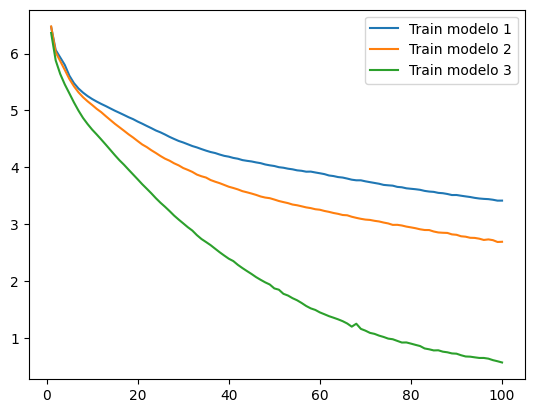

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='Train modelo 1')
sns.lineplot(x=epoch_count,  y=hist2.history['loss'], label='Train modelo 2')
sns.lineplot(x=epoch_count,  y=hist3.history['loss'], label='Train modelo 3')
#sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='valid')
plt.show()

<Axes: >

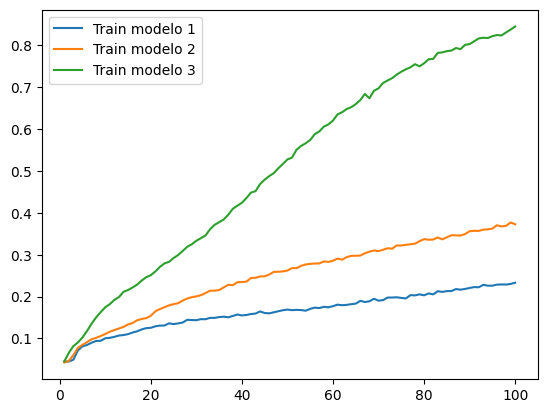

In [32]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='Train modelo 1')
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='Train modelo 2')
sns.lineplot(x=epoch_count,  y=hist3.history['accuracy'], label='Train modelo 3')


### Predicción de próxima palabra

In [33]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [34]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/

!pip install -q gradio 

In [35]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = model3.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [36]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [37]:
input_text='Durante 8 minutos'

generate_seq(model3, tok, input_text, max_length=max_context_size, n_words=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


'Durante 8 minutos porque precisa'

###  Beam search y muestreo aleatorio

In [38]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [39]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [41]:
# Greedy search
input_text = "Tiene 45"
generated_sequence_greedy = generate_seq(model3, tok, input_text, max_length=max_context_size, n_words=6)
print("Greedy Search:")
print(generated_sequence_greedy)

# Beam search determinista
salidas_deterministic = beam_search(model3, num_beams=1, num_words=6, input=input_text)
generated_sequence_beam_det = decode(salidas_deterministic[0])
print("\nBeam Search Deterministic:")
print(generated_sequence_beam_det)

# Beam search estocástico con temperatura
salidas_stochastic = beam_search(model3, num_beams=10, num_words=6, input=input_text)
generated_sequence_beam_stoc = decode(salidas_stochastic[0])
print("\nBeam Search Estocástico:")
print(generated_sequence_beam_stoc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Greedy Search:
Tiene 45 segundos para preguntar 15 segundos y
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Beam Search Deterministic:
['tiene 45 segundos para terminar porque viví y']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

### Conclusiones
El modelo no alcanzó un rendimiento satisfactorio durante el proceso de entrenamiento, mostrando signos de sobreajuste. A pesar de los esfuerzos realizados para abordar esta problemática mediante la utilización de conjuntos de datos más extensos y la exploración de diversas arquitecturas de red, incluyendo GRU, LSTM y Bidireccionales, no se logró una reducción en la perplejidad del modelo.

Además, al experimentar con distintas estrategias de generación de secuencias, como greedy search, beam search determinista y beam search estocástico, no se observaron mejoras sustanciales en el desempeño general del modelo.